In [1]:
import sqlite3 
import pandas as pd 
import numpy as np 
import datetime 
import os 
import plotly.express as px
import sys


In [2]:
sys.path.append('/home/malcolm/WorkTransit/scripts/')
from WorkTransitLib import RawDirections as rd
rev_locations = {v:k for k, v in rd.locations.items()}
rd.locations

{'home': '120 Benchley Pl, Bronx NY',
 'work': '809 Washington Street',
 'bxbark': '830 Pelham Pkwy, Pelham Manor, NY 10803',
 'orchard_beach': 'Orchard Beach, Bronx, NY 10464'}

In [3]:
%load_ext autoreload
%autoreload 2

# Make it Classy

In [4]:
def gb_summary_func(df):
    out = {}
    out['Count'] = df.shape[0]
    out['Avg Duration Traffic hr'] = np.round(df['duration_in_traffic_hr'].mean(), 2)
    out['Stdev Duration Traffic hr'] = np.round(df['duration_in_traffic_hr'].std(), 2)
    out['Avg Duration Traffic text'] = str(np.round(out['Avg Duration Traffic hr'] * 60, 2) ) + ' mins'
    out['Stdev Duration Traffic text'] = str(np.round(out['Stdev Duration Traffic hr'] * 60, 2) ) + ' mins'
    out['Avg Duration Mins num'] = np.round(out['Avg Duration Traffic hr'] * 60, 2)
    out['Stdev Duration Min num'] = np.round(out['Stdev Duration Traffic hr'] * 60, 2)
    out['Avg Duration Traffic Mins num'] = np.round(out['Avg Duration Traffic hr'] * 60, 2)
    out['Earliest Time'] = df['Time'].min()
    out['Latest Time'] = df['Time'].max()
    out['Earliest Date'] = df['Date'].min()
    out['Latest Date'] = df['Date'].max()
    out['Days w/ Data'] = df['Date'].nunique()
    out_series = pd.Series(out)
    return(out_series)

In [5]:
def create_leave_time_gb(df, with_col='Day of Week'):
    time_gb = df.set_index('departure_time_time')\
        .groupby([with_col, pd.Grouper(freq='20T')])\
        .apply(lambda x: gb_summary_func(x))
    time_gb2 = time_gb.reset_index()
    time_gb2['Earliest Start Time'] = pd.to_datetime(time_gb2['Earliest Time'])
    return(time_gb2)


In [6]:
def create_avg_time_plot(gb_df, seg_field = 'Day of Week', routename = 'Unknown'):
    fig = px.line(gb_df, 'Earliest Start Time', 'Avg Duration Mins num'
           , color=seg_field, markers=True
           , title = "Avg Time to dest by Leave Time by Route - " + routename)
    return(fig)

In [7]:
class SummarizeDriving():
    
    def __init__(self, **kwargs):
        self.db_path='/home/malcolm/WorkTransit/data/transit.db'
        self.end_dt = datetime.datetime.now()
        self.end_str = str(self.end_dt.date())
        n_days=14
        self.start_dt = self.end_dt - datetime.timedelta(days=n_days)
        self.start_str = str(self.start_dt.date())
        self.image_save_path = '/home/malcolm/WorkTransit/images/'
        os.makedirs(self.image_save_path, exist_ok=True)
        self.__dict__.update(**kwargs)        
        
        self.image_paths = []
        self.output_dfs = {}
    
    def create_con(self):
        self.con = sqlite3.connect(self.db_path)
        self.cursor =self. con.cursor()
        self.cursor.execute('SELECT name FROM sqlite_master WHERE type=\'table\' ORDER BY name')
        tables = self.cursor.fetchall()
        tables = [x[0] for x in tables]
        print("Tables: ", tables)
    
    def load_data(self):
        # Load Data with Modifications
        df = pd.read_sql(f""" 
        select * 
        from parsed_driving
        where Date between '{self.start_str}' and '{self.end_str}'
        order by Date
        """, self.con)
        print(df.shape)
        df['departure_time'] = pd.to_datetime(df['departure_time'])
        df['departure_time_time'] = df['departure_time'].apply(lambda x: x - pd.Timestamp(x.date()))
        df['origin_name'] = df['origin'].apply(lambda x: rev_locations.get(x, 'Unknown'))
        df['destination_name'] = df['destination'].apply(lambda x: rev_locations.get(x, 'Unknown'))
        df['Day of Week'] = df['departure_time'].dt.dayofweek.astype(str) + '-' + df['departure_time'].dt.day_name()
        df = df.rename({'summary':'route'}, axis=1)
        self.df = df.copy()
        
    def one_route_pipeline(self, origin_name, dest_name):
        routename = origin_name + ' - ' + dest_name
        route1 = self.df[(self.df['origin_name'] == origin_name) 
                & (self.df['destination_name'] == dest_name)  
    #             & (df['Date'] == day1)
               ]
        time_gb = create_leave_time_gb(route1, 'Day of Week')
        route_gb = create_leave_time_gb(route1, 'route')
        
        time_plot = create_avg_time_plot(time_gb, 'Day of Week', routename)
        route_plot = create_avg_time_plot(route_gb, 'route', routename)
        
        time_plot_path = self.image_save_path + 'time_plot_'+routename+'.png'
        route_plot_path = self.image_save_path + 'route_plot_'+routename+'.png'
        time_plot.write_image(time_plot_path)
        route_plot.write_image(route_plot_path)
        
        self.image_paths.extend([time_plot_path, route_plot_path])
        print("Saved Images for ", routename)
        
        df_summ = gb_summary_func(route1)
        df_summ = pd.DataFrame(df_summ).T\
            .drop(['Avg Duration Traffic hr', 'Stdev Duration Traffic hr', 
                  'Avg Duration Mins num', 'Stdev Duration Min num', 'Avg Duration Traffic Mins num'], axis=1)
        df_summ = df_summ.rename({0:routename})
        return(df_summ)

        
    def run_multiple_trips(self):
        self.summ_dicts = []
        pairs = [
            {'origin_name' : 'home',   'dest_name': 'work'},
            {'origin_name' : 'work',   'dest_name': 'home'},
            {'origin_name' : 'bxbark', 'dest_name': 'work'},
            {'origin_name' : 'work',   'dest_name': 'bxbark'},
        ]
        for pair in pairs:
            rslt = self.one_route_pipeline(**pair)
            self.summ_dicts.append(rslt)
            
        self.trip_summary_df = pd.concat(self.summ_dicts)
        self.output_dfs['Trip Summary'] = self.trip_summary_df
            
    
    def execute(self):
        self.create_con()
        self.load_data()
        self.run_multiple_trips()

In [8]:
driving_sum = SummarizeDriving()
driving_sum.execute()

Tables:  ['Raw_Responses', 'parsed_driving', 'parsed_transit']
(1731, 17)
Saved Images for  home - work
Saved Images for  work - home
Saved Images for  bxbark - work
Saved Images for  work - bxbark


In [11]:
driving_sum.one_route_pipeline('home', 'work')

Saved Images for  home - work


,Count,Avg Duration Traffic text,Stdev Duration Traffic text,Earliest Time,Latest Time,Earliest Date,Latest Date,Days w/ Data
home - work,129,54.6 mins,13.2 mins,07:03,09:48,2021-11-15,2021-11-26,10


In [12]:
from IPython.display import Image


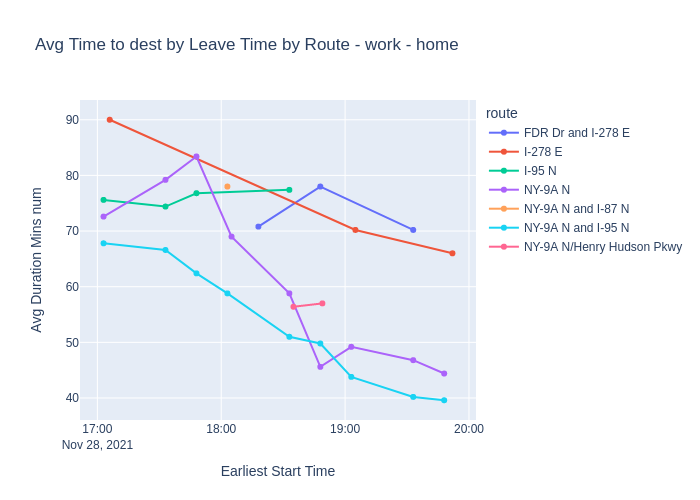

In [13]:
Image(driving_sum.image_paths[3])

In [ ]:
def create_con(db_path='/home/malcolm/WorkTransit/data/transit.db'):
    con = sqlite3.connect(db_path)
    cursor = con.cursor()
    cursor.execute('SELECT name FROM sqlite_master WHERE type=\'table\' ORDER BY name')
    tables = cursor.fetchall()
    tables = [x[0] for x in tables]
    print("Tables: ", tables)
    return(con, cursor)

In [ ]:
con, cursor = create_con()

In [ ]:
today = datetime.datetime.now()
today_str = str(today.date())
two_weeks = today - datetime.timedelta(days=7)
two_weeks_str = str(two_weeks.date())
print("Today: ", today_str, "Two weeks: ", two_weeks_str)

# Driving

## Load Data

In [ ]:
# Demo with Raw Data
df = pd.read_sql(f""" 
select * 
from Raw_Responses
where Date between '{two_weeks_str}' and '{today_str}'
order by Date desc
""", con)
print(df.shape)
df.head()

In [ ]:
# Load Data with Modifications
df = pd.read_sql(f""" 
select * 
from parsed_driving
where Date between '{two_weeks_str}' and '{today_str}'
order by Date
""", con)
print(df.shape)
df['departure_time'] = pd.to_datetime(df['departure_time'])
df['origin_name'] = df['origin'].apply(lambda x: rev_locations.get(x, 'Unknown'))
df['destination_name'] = df['destination'].apply(lambda x: rev_locations.get(x, 'Unknown'))
df['Day of Week'] = df['departure_time'].dt.dayofweek.astype(str) + '-' + df['departure_time'].dt.day_name()
df.head()

In [ ]:
df['Day of Week'].value_counts()

In [ ]:
df.groupby(['Day of Week', 'origin_name', 'destination_name']).count()['summary']

In [ ]:
df.groupby('Date').count()

In [ ]:
df.groupby(['Date', 'origin', 'destination']).count()

In [ ]:
df.groupby(['origin', 'destination', 'summary']).count().sort_values('duration_hr', ascending=False)

In [ ]:
def gb_summary_func(df):
    out = {}
    out['Count'] = df.shape[0]
    out['Avg Duration Traffic hr'] = np.round(df['duration_in_traffic_hr'].mean(), 2)
    out['Stdev Duration Traffic hr'] = np.round(df['duration_in_traffic_hr'].std(), 2)
    out['Avg Duration Traffic text'] = str(np.round(out['Avg Duration Traffic hr'] * 60, 2) ) + ' mins'
    out['Stdev Duration Traffic text'] = str(np.round(out['Stdev Duration Traffic hr'] * 60, 2) ) + ' mins'
    out['Avg Duration Mins num'] = np.round(out['Avg Duration Traffic hr'] * 60, 2)
    out['Stdev Duration Min num'] = np.round(out['Stdev Duration Traffic hr'] * 60, 2)
    out['Avg Duration Traffic Mins num'] = np.round(out['Avg Duration Traffic hr'] * 60, 2)
    out['Earliest Time'] = df['Time'].min()
    out['Latest Time'] = df['Time'].max()
    out['Earliest Date'] = df['Date'].min()
    out['Latest Date'] = df['Date'].max()
    out_series = pd.Series(out)
    return(out_series)

In [ ]:
df.columns

In [ ]:
origin_dest_cnts = df.groupby(['origin', 'destination'])['summary'].count()\
    .rename('Total Counts', axis=0)
origin_dest_cnts

In [ ]:
gb_summary = df.groupby(['origin', 'destination', 'summary']).apply(lambda x: gb_summary_func(x))
gb_summary2 = pd.merge(gb_summary, origin_dest_cnts
         , left_index=True, right_index=True )
gb_summary2['Summary %'] = np.round(100 * gb_summary2['Count']/gb_summary2['Total Counts'], 1)

gb_summary2[gb_summary2['Count'] >= 10]\
    .drop(['Avg Duration Traffic hr', 'Stdev Duration Traffic hr'], axis=1)\
    .sort_values(['origin', 'destination', 'Count'], ascending=False)

In [ ]:
gb_summary2 = pd.merge(gb_summary, origin_dest_cnts
         , left_index=True, right_index=True )
gb_summary2['Summary %'] = np.round(100 * gb_summary2['Count']/gb_summary2['Total Counts'], 1)
gb_summary2.head()

## One Route 

Analyses requested.... by route, by day, by time 
metrics - average time to destination, min, max, (# of trips used in measurements) 

Overall fastest times, overall slowest times....

By trip (source and destination) 

In [ ]:
origin1 = '120 Benchley Pl, Bronx NY'
dest1 = '809 Washington Street'
# day1 = df['Date'].max()

In [ ]:
route1 = df[(df['origin'] == origin1) 
            & (df['destination'] == dest1)  
#             & (df['Date'] == day1)
           ]
print("Shape: ", route1.shape)
route1

In [ ]:
origin_name = route1['origin_name'].value_counts().index[0]
dest_name = route1['destination_name'].value_counts().index[0]
routename = f"{origin_name} to {dest_name}"
print(routename)

## By Day of Week and Route Graphs

In [ ]:
route2 = route1.copy()
route2['departure_time_time'] = route2['departure_time'].apply(lambda x: x - pd.Timestamp(x.date()))

time_gb = route2.set_index('departure_time_time')\
    .groupby(['Day of Week', pd.Grouper(freq='20T')])\
    .apply(lambda x: gb_summary_func(x))
print("Destination: ", dest1, " Origin: ", origin1)
time_gb2 = time_gb.reset_index()
time_gb2['Earliest Time2'] = pd.to_datetime(time_gb2['Earliest Time'])

time_gb

In [ ]:
summary_gb = route2.set_index('departure_time_time')\
    .groupby(['summary', pd.Grouper(freq='20T')])\
    .apply(lambda x: gb_summary_func(x))
print("Destination: ", dest1, " Origin: ", origin1)

summary_gb2 = summary_gb.reset_index()
summary_gb2['Earliest Time2'] = pd.to_datetime(summary_gb2['Earliest Time'])
summary_gb

In [ ]:
px.scatter(time_gb2, 'Earliest Time2', 'Avg Duration Mins num'
       , color='Day of Week'
       , title = "Avg Time to dest by Leave Time by Day of Week - " + routename
       , mode='lines+markers' )

In [ ]:
import plotly

In [ ]:
plotly.__version__

In [ ]:
px.line(time_gb2, 'Earliest Time2', 'Avg Duration Mins num'
       , color='Day of Week'
       , title = "Avg Time to dest by Leave Time by Day of Week - " + routename)

In [ ]:
px.line(summary_gb2, 'Earliest Time2', 'Avg Duration Mins num'
       , color='summary'
       , title = "Avg Time to dest by Leave Time by Route - " + routename)

## Metrics

In [ ]:
df_summ = gb_summary_func(route1)
pd.DataFrame(df_summ).T\
    .drop(['Avg Duration Traffic hr', 'Stdev Duration Traffic hr', 
          'Avg Duration Mins num', 'Stdev Duration Min num', 'Avg Duration Traffic Mins num'], axis=1)


# Transit 